# Homework 3 - RL
Традиционно, Ваш ноутбук должен быть воспроизводим. Не забудьте сохранить Output   
Загружать ноутбук сюда: http://bit.ly/dafe_hw 

In [1]:
import gym
import numpy as np
import itertools
from collections import defaultdict
from gym.envs import toy_text
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Part 1 - Tabular Q-learning [30]

Реализуем алгоритм Q-learning для среды CliffWalking. 

Посмотрим, что из себя представляет среда CliffWalking <img src="cliffwalking.png" width="500">

In [2]:
env = toy_text.CliffWalkingEnv()

In [3]:
print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


Так как награда выражатеся отрицательными значениями, то фактической целью агента является как можно более быстрое преодоление пути от старта к финишу при этом ему нужно не упасть с обрыва.

Традиционно посмотрим сколько очков в среднем за 100 эпизодов сможет набрать "cлучайный" агент.

In [4]:
total_reward = []
for episode in range(100):
    episode_reward = 0
    observation = env.reset()
    for t in range(100):
#         env.render()
        action = env.action_space.sample()
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            print("Episode {} finished after {} timesteps".format(episode+1, t+1))
            break
    total_reward.append(episode_reward)

Episode 100 finished after 69 timesteps


In [5]:
print(np.mean(total_reward))

-1144.14


Ожидаемо, наш "случайный" агент просто блуждает по среде, не пытаясь добраться до цели.

Вспомним как выглядит реализация данного алгоритма <img src="q_learning.png" width="500">

Так как мы раелизуем табличную версию Q-learning, создадим структура, которая будет хранить значения нашей функции *Q(S,A)* для каждого состояния и действия. Она пдетставляет собой словарь (*dict*), хранящий в качестве ключей состояния, а в качестве значений массив значений *Q-функции* для каждого действия для данного ключа-состояния.

In [6]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))

print("Q-значения для состояния-действия (0, 0): %s" % Q[(0, 0)], "хранятся в списке, по значению для каждого действия")
print("Таким обарзом, Q-значение для действия 3 в в состоянии (1,2), i.e. Q((1,2), 3), можно получить вот так q_vals[(1,2)][3]:", Q[(1,2)][3])

Q-значения для состояния-действия (0, 0): [0. 0. 0. 0.] хранятся в списке, по значению для каждого действия
Таким обарзом, Q-значение для действия 3 в в состоянии (1,2), i.e. Q((1,2), 3), можно получить вот так q_vals[(1,2)][3]: 0.0


Сначала напишем функцию реализующую $\epsilon$-greedy политику для исследования среды.

In [7]:
def eps_greedy(Q, epsilon, state):
    """
    Параметры:
        Q: таблица значений Q-функции
        epsilon: параметр эпсилон
        state: текущее состоние
    Результат:
        Случайное действие с вероятностью eps или argmax Q(s, .) c вероятностью (1 - eps)
        random action with probability of eps; argmax Q(s, .) with probability of (1-eps)
    """
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(Q[state])

Также напишем функцию, которая поможет нам оценить, как ведет себя обученный агент.

In [8]:
def q_eval(Q, render=True):
    total_reward = []
    for i_episode in range(100):
        episode_reward = 0
        observation = env.reset()
        for t in range(100):
            if render:
                env.render()
            action = np.argmax(Q[observation])
            observation, reward, done, info = env.step(action)
            episode_reward += reward
            if done:
                print("Episode {} finished after {} timesteps".format(i_episode+1, t+1))
                break
        total_reward.append(episode_reward)
    return np.mean(total_reward)

Теперь реализуем функцию обучения агента (обновления значений Q-функции) с использование функции, реализующей $\epsilon$-greedy политику.

In [13]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """    
    Параменты:
        env: среда Open AI
        num_episodes: Количество эпизодов
        discount_factor: фактор дисконтирования
        alpha: константа обучения
        epsilon: параметр эпсилон для ϵ-greedy политику
    
    Результат:
        Таблица с оптимальными значениями Q-функции
    """
    q_values = defaultdict(lambda: np.zeros(env.action_space.n))

    episode_lengths=np.zeros(num_episodes)
    episode_rewards=np.zeros(num_episodes)
        
    for i_episode in range(num_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
        
        state = env.reset()
        done = False
        reward_sum = 0
        
        while not done:            
            # Choose action        
            action = eps_greedy(q_values, epsilon, state)
            # Do the action
            next_state, reward, done, info = env.step(action)
            reward_sum += reward
            # Update q_values       
            td_target = reward + 0.9 * np.max(q_values[next_state])
            td_error = td_target - q_values[state][action]
            q_values[state][action] += alpha * td_error
            # Update state
            state = next_state

            
        np.append(episode_rewards, reward_sum)
    
    return q_values, episode_lengths, episode_rewards

In [14]:
env = toy_text.CliffWalkingEnv()

In [15]:
Q, episode_lengths, episode_rewards = q_learning(env, 500)

Episode 500/500.

In [16]:
print(np.mean(episode_rewards))

0.0


In [17]:
score = q_eval(Q, render=False)

Episode 1 finished after 13 timesteps
Episode 2 finished after 13 timesteps
Episode 3 finished after 13 timesteps
Episode 4 finished after 13 timesteps
Episode 5 finished after 13 timesteps
Episode 6 finished after 13 timesteps
Episode 7 finished after 13 timesteps
Episode 8 finished after 13 timesteps
Episode 9 finished after 13 timesteps
Episode 10 finished after 13 timesteps
Episode 11 finished after 13 timesteps
Episode 12 finished after 13 timesteps
Episode 13 finished after 13 timesteps
Episode 14 finished after 13 timesteps
Episode 15 finished after 13 timesteps
Episode 16 finished after 13 timesteps
Episode 17 finished after 13 timesteps
Episode 18 finished after 13 timesteps
Episode 19 finished after 13 timesteps
Episode 20 finished after 13 timesteps
Episode 21 finished after 13 timesteps
Episode 22 finished after 13 timesteps
Episode 23 finished after 13 timesteps
Episode 24 finished after 13 timesteps
Episode 25 finished after 13 timesteps
Episode 26 finished after 13 times

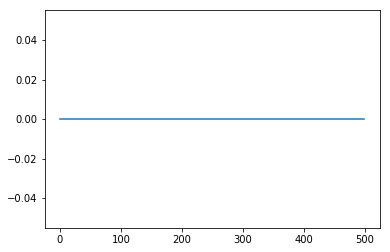

In [18]:
plt.plot(episode_lengths);

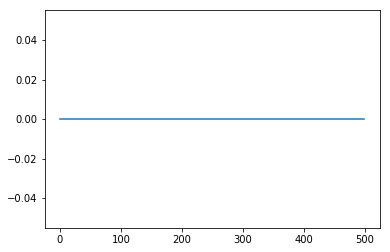

In [19]:
plt.plot(episode_rewards);

# Part 2 - Approx Q-Learning [70%]

Вам предстоит научиться сажать космисеческий корабль в среде [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/)


Используйте Approx Q-Learning и repaly buffer
 
Для того, чтобы получить полные баллы, ваш корабль должен садиться 10 раз из 10.
  
Если меньше, то баллы будут снижены пропорционально. 

In [20]:
import gym
import random
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [21]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/home/keleas/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Model

In [22]:
class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_size = 64, fc2_size = 64):
        """
        state_size (int): Dimension of each state
        action_size (int): Dimension of each action
        seed (int): Random seed
        """
        super(DuelingQNetwork, self).__init__()
        self.num_actions = action_size
        fc3_1_size = fc3_2_size = 32
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        
        # The one that calculate V(s)
        self.fc3_1 = nn.Linear(fc2_size, fc3_1_size)
        self.fc4_1 = nn.Linear(fc3_1_size, 1)
        # The one that calculate A(s,a)
        self.fc3_2 = nn.Linear(fc2_size, fc3_2_size)
        self.fc4_2 = nn.Linear(fc3_2_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        val = F.relu(self.fc3_1(x))
        val = self.fc4_1(val)
        
        adv = F.relu(self.fc3_2(x))
        adv = self.fc4_2(adv)
        
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        action = val + adv - adv.mean(1).unsqueeze(1).expand(state.size(0), self.num_actions)
        return action

## Agent

In [48]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32  # minibatch size
GAMMA = 0.99  # discount factor
TAU = 1e-3  # for soft update of target parameters
LR = 5e-4  # learning rate 
UPDATE_EVERY = 4  # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
class ReplayBuffer:
    """ Fixed-size buffer to store experience tuples """

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        action_size (int): dimension of each action
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """ Add a new experience to memory """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """ Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """ Return the current size of internal memory """
        return len(self.memory)

In [50]:
class Agent():
    def __init__(self, state_size, action_size, seed):
        """
        state_size (int): dimension of each state
        action_size (int): dimension of each action
        seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = torch.optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience 
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn_DDQN(experiences, GAMMA)

    def act(self, state, eps=0.):
        """
        Returns actions for given state as per current policy
            
        state (array_like): current state
        eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """
        Update value parameters using given batch of experience tuples
        
        experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  
        
       
    def learn_DDQN(self, experiences, gamma):
        """
        Update value parameters using given batch of experience tuples
        
        experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        Q_argmax = self.qnetwork_local(next_states).detach()
        _, a_prime = Q_argmax.max(1)
        
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, a_prime.unsqueeze(1)) 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  

    def soft_update(self, local_model, target_model, tau):
        """
        Soft update model parameters
        θ_target = τ*θ_local + (1 - τ)*θ_target
        
        local_model (PyTorch model): weights will be copied
        target_model (PyTorch model): weights will be copied
        tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Train 

Episode 100	Average Score: -202.72
Episode 200	Average Score: -106.66
Episode 300	Average Score: 6.51751
Episode 400	Average Score: 96.06
Episode 500	Average Score: 109.56
Episode 600	Average Score: 156.35
Episode 700	Average Score: 211.78
Episode 714	Average Score: 220.21
Environment solved in 614 episodes!	Average Score: 220.21


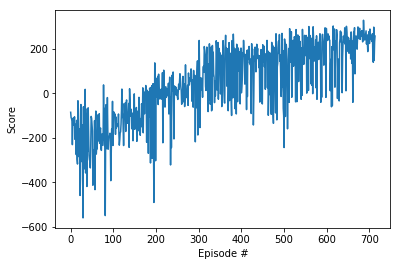

In [51]:
agent = Agent(state_size=8, action_size=4, seed=0)
# agent.qnetwork_local.load_state_dict(torch.load('checkpoint_Dueling_DDQN.pth', map_location=lambda storage, loc: storage))


def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    eps_end (float): minimum value of epsilon
    eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=300.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_Dueling_DDQN.pth')
            break
    return scores

scores = train()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Results 

KeyboardInterrupt: 

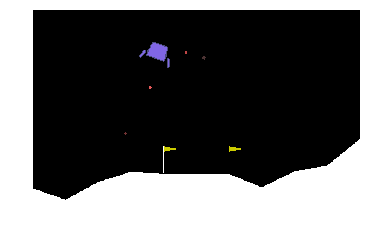

In [52]:
agent = Agent(state_size=8, action_size=4, seed=0)
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_Dueling_DDQN.pth', map_location=lambda storage, loc: storage))

for i in range(10):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        plt.savefig('4video/' + 'file{}{}.png'.format(j, i))
        if done:
            break 
            
env.close()

## Make video prove 

In [ ]:
import cv2
import os

In [ ]:
image_folder = '4video'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 30, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

### [link]() for video

Традиционно, Ваш ноутбук должен быть воспроизводим. Не забудьте сохранить Output   
Загружать ноутбук сюда: http://bit.ly/dafe_hw 